In [1]:
import torch.nn as nn
from torchvision.models import resnet18,vgg19,googlenet
import torch
import torchvision
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#switch to execute the desired model
vgg19_switch = True
resnet18_switch = False
googlenet_switch = False

In [3]:
if vgg19_switch:
    DIR = '/Users/sudiptamondal/Documents/QMUL/Deep Learning with Computer Vision/DL CV Project/MNIST_VGG19/'
if resnet18_switch:
    DIR = '/Users/sudiptamondal/Documents/QMUL/Deep Learning with Computer Vision/DL CV Project/MNIST_RESNET18/'
if googlenet_switch:
    DIR = '/Users/sudiptamondal/Documents/QMUL/Deep Learning with Computer Vision/DL CV Project/MNIST_GOOGLENET/'

In [4]:
MODEL_PATH = os.path.join(DIR,'model.pth')

In [5]:
classes = ['0', '1', '2', '3', '4','5', '6', '7', '8', '9']

In [6]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [7]:
if resnet18_switch or googlenet_switch:
    test_data = torchvision.datasets.MNIST('Data', train=False, download=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
if vgg19_switch:
    test_data = torchvision.datasets.MNIST('Data', train=False, download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.Resize(32),
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

In [8]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

In [9]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)),cmap='gray', interpolation='none')  # convert from Tensor image

<ipython-input-10-adfb733c5062>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 10 / 2, idx + 1, xticks=[], yticks=[])


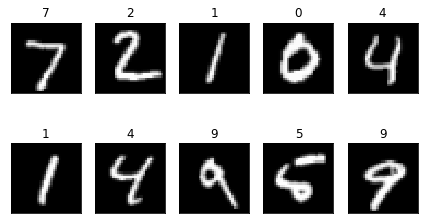

In [10]:
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure()
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10 / 2, idx + 1, xticks=[], yticks=[])
    plt.tight_layout()
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [11]:
""" GoogleNet"""
class GoogleNet(nn.Module):
  def __init__(self):
    super(GoogleNet,self).__init__()
    # define model
    self.model = googlenet(pretrained=False,num_classes=10,aux_logits=False)
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

  def forward(self,x):
    return self.model(x)

In [12]:
""" VGG19"""
class VGG19(nn.Module):
  def __init__(self):
    super(VGG19,self).__init__()
    # define model
    self.model = vgg19(pretrained=False,num_classes=10)
    self.model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

  def forward(self,x):
    return self.model(x)

In [13]:
""" Resnet18"""
class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18,self).__init__()
    # define model
    self.model = resnet18(pretrained=False,num_classes=10)
    """
    In order to adapt Resnet18 for MNIST input layer needs to accept single channel instead of 3
    (MNIST images are single-channel = grayscale, whereas ImageNet are 3-channels = RGB)
    """
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

  def forward(self,x):
    return self.model(x)

In [14]:
#trained on GPU but load on CPU
device = torch.device('cpu')
if resnet18_switch:
    network = ResNet18()

if vgg19_switch:
    network = VGG19()

if googlenet_switch:
    network = GoogleNet()
    
#load model
network.load_state_dict(torch.load(MODEL_PATH,map_location=device))

<All keys matched successfully>

<ipython-input-15-56ec63e28ffe>:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


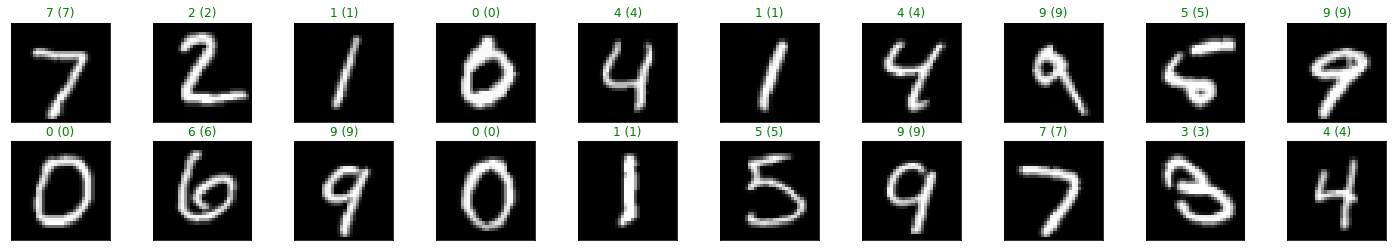

In [15]:
"""Visualise the model's output from a trained model"""
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.to(device)

# get sample outputs
output = network(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

plt.savefig(DIR+'MNIST_inference.png')
plt.show()
plt.close()